# ML for Texts

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [2]:
import math
import re
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import spacy
from lightgbm import LGBMClassifier

from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [4]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
# Checking for duplicate entries
print(df_reviews.duplicated().sum())

# Removing missing entries
df_reviews = df_reviews.dropna()
print(df_reviews.isna().sum())

0
tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64


In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


The DataFrame consists of 47329 entries and 17 coulmns of data:

**Data:**
- `tconst` - Unique ID
- `title_type`
- `primary_title`
- `original_title`
- `start_year`
- `end_year`
- `runtime_minutes` - Length of movie in minutes
- `is_adult` - $0-1$
- `genres`
- `average_rating` (Per Movie)
- `votes` - Num. of votes used to calculate `average_rating`
- `rating` - $1-10$
- `sp` (pos, neg)
- `idx` 

The only columns relevant to this project are:

**Review Text:**
- `review` - Content of review

**Target:** 
- `pos` - Positive(1) or negative(0) review

**Train-test:**
- `ds_part` - Denotes training and test dataset

## EDA

Let's check the number of movies and reviews over years.

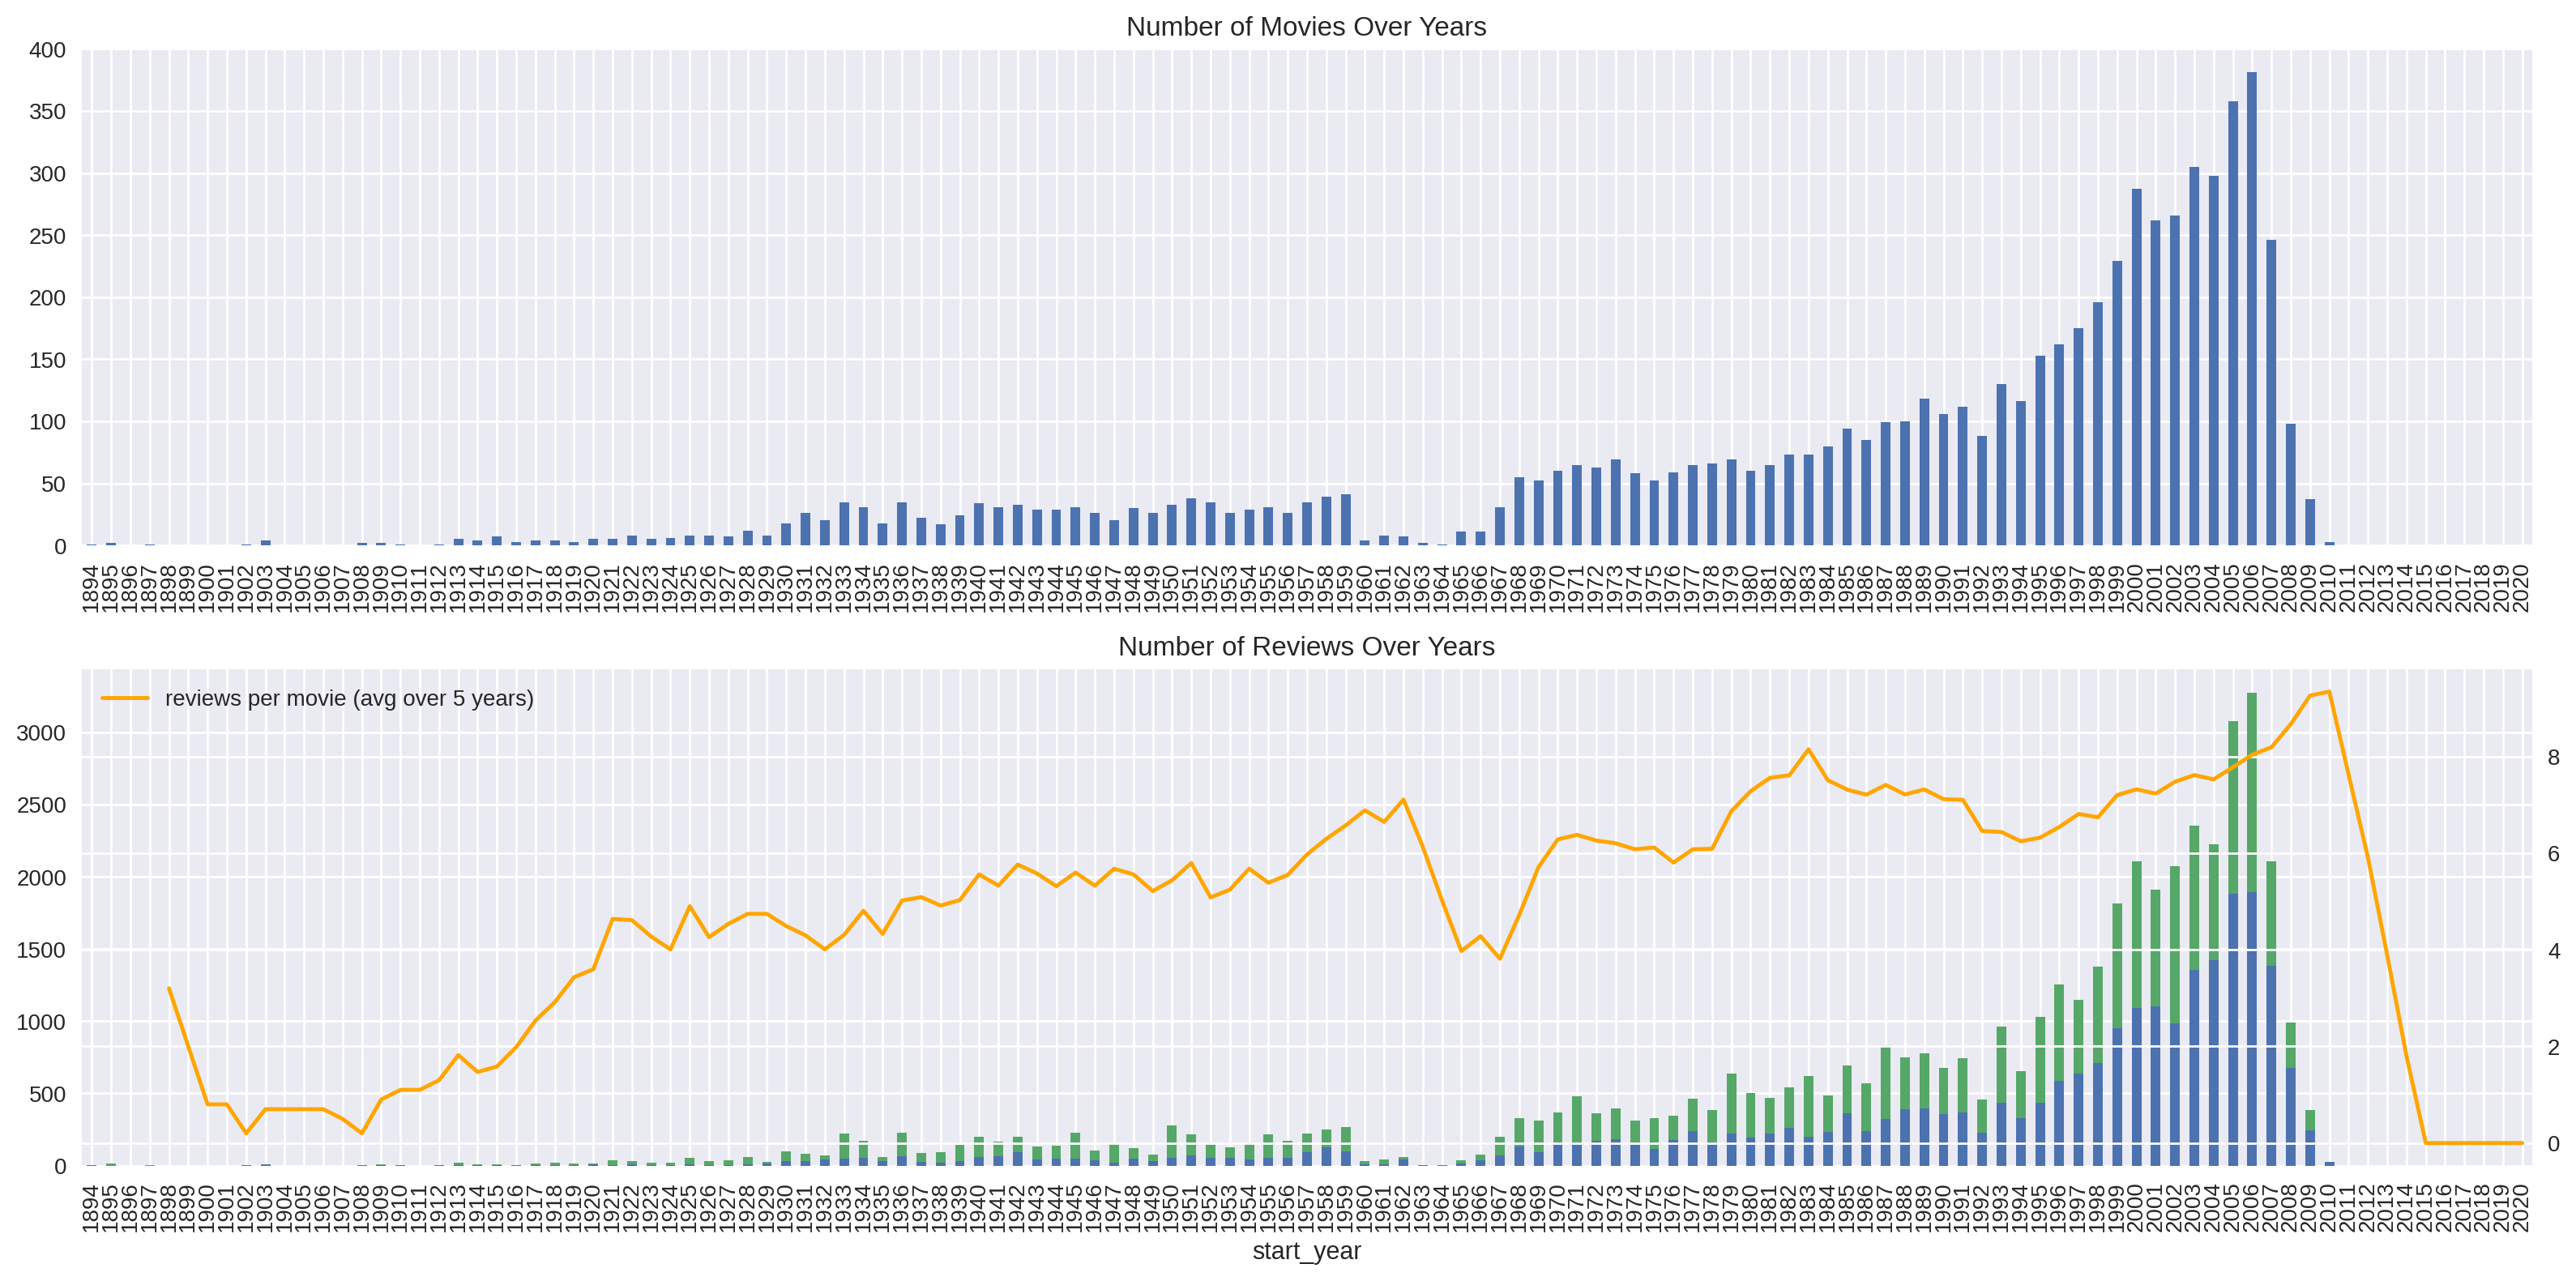

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

We can see that although the movie industry has really only boomed in the late 1990's into to 2000's, the 5 year average number of movie reviews has remained somewhat consistently large since the 1920's. The average fell in the years after 1960, reflecting the fall in the movie industry at the same time. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

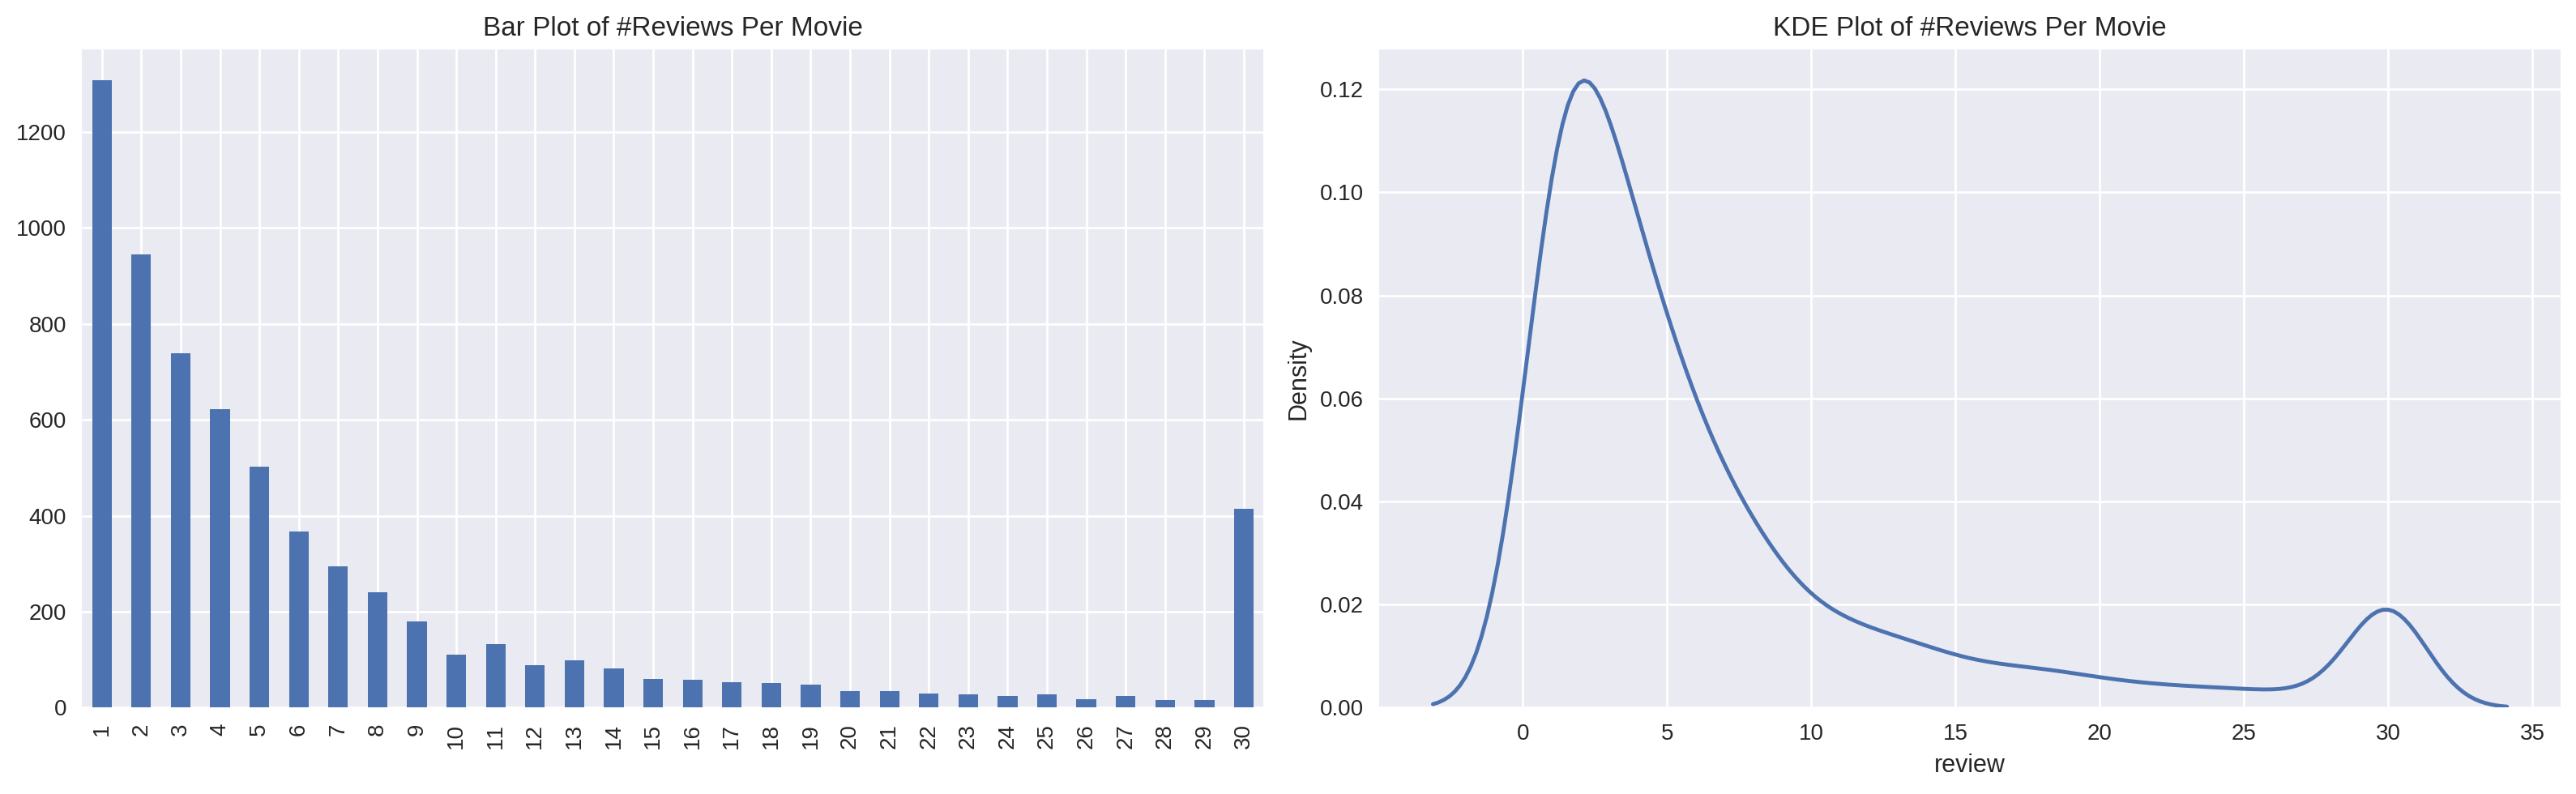

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

These graphs show that most movies only have a few reviews, <= 11. It also shows 30 as an outlier. We can assume this is the max amount of reviews per movie in the dataset, though we can assume that the gradual decent shown would continue were the dataset not limited.

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

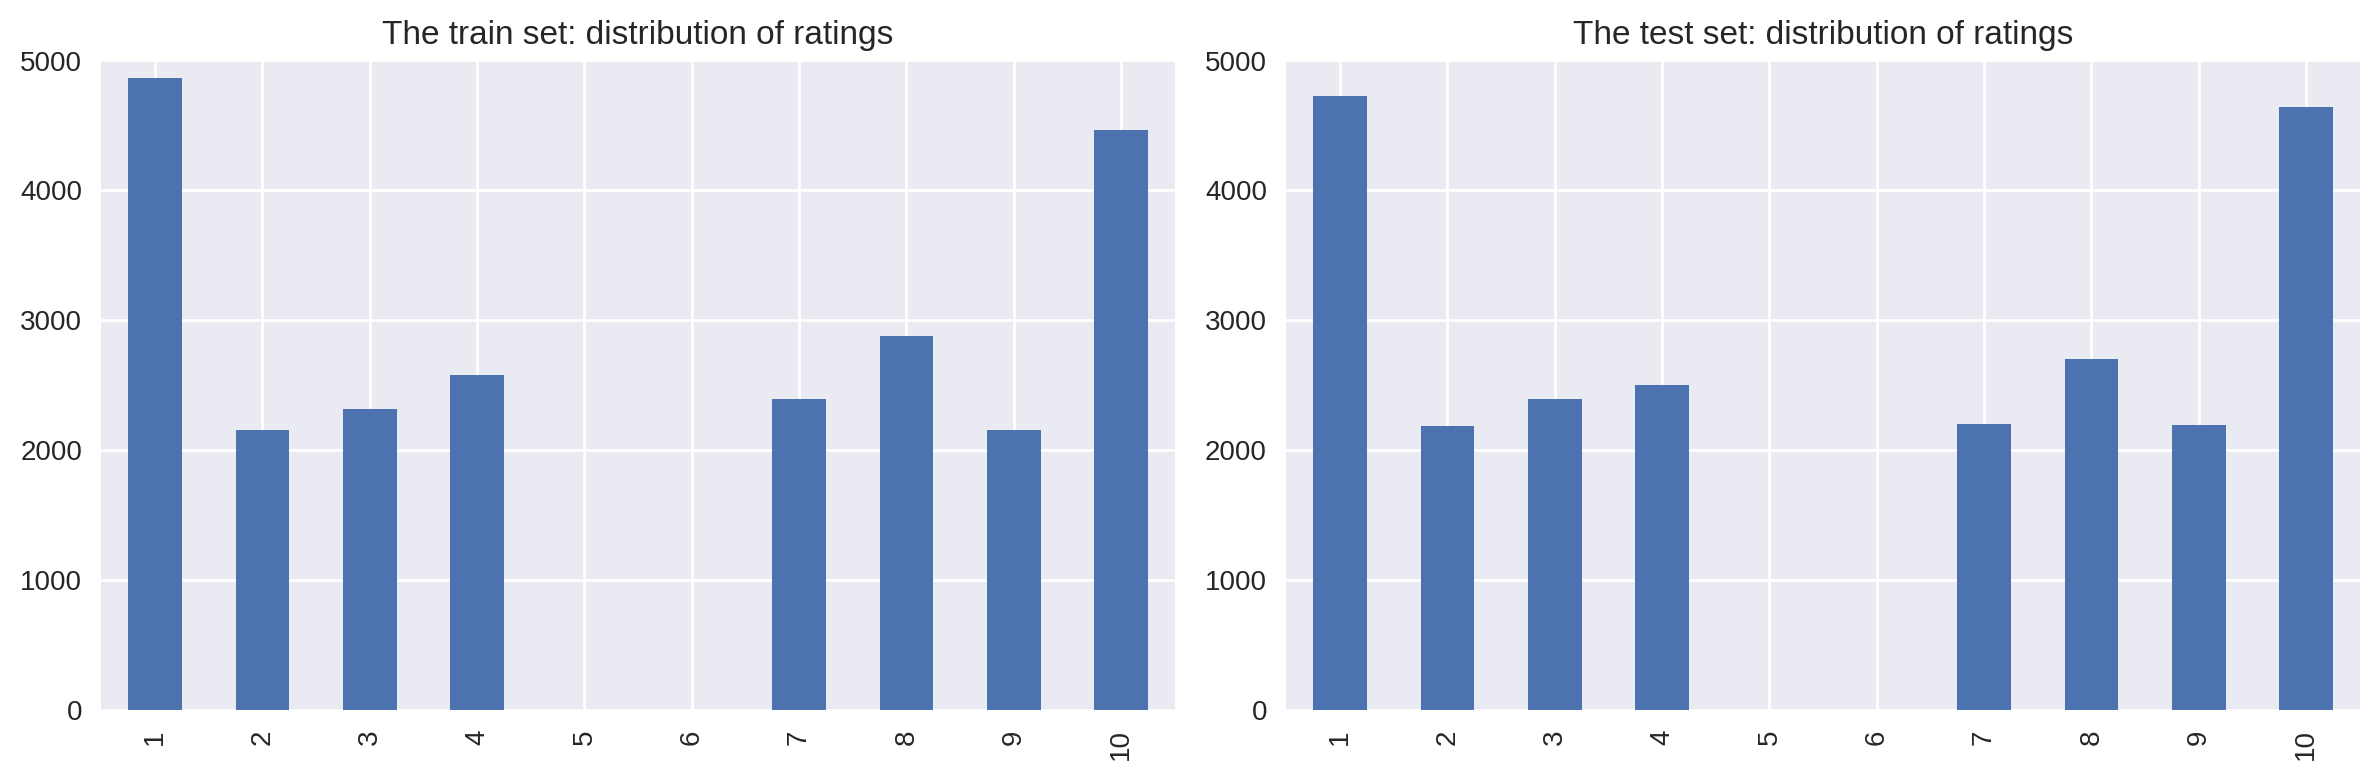

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

These graphs show that the preset training and test datasets have an extemely similar distribution of ratings, indicating that they should also have a similar distribution of positive and negative reviews.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


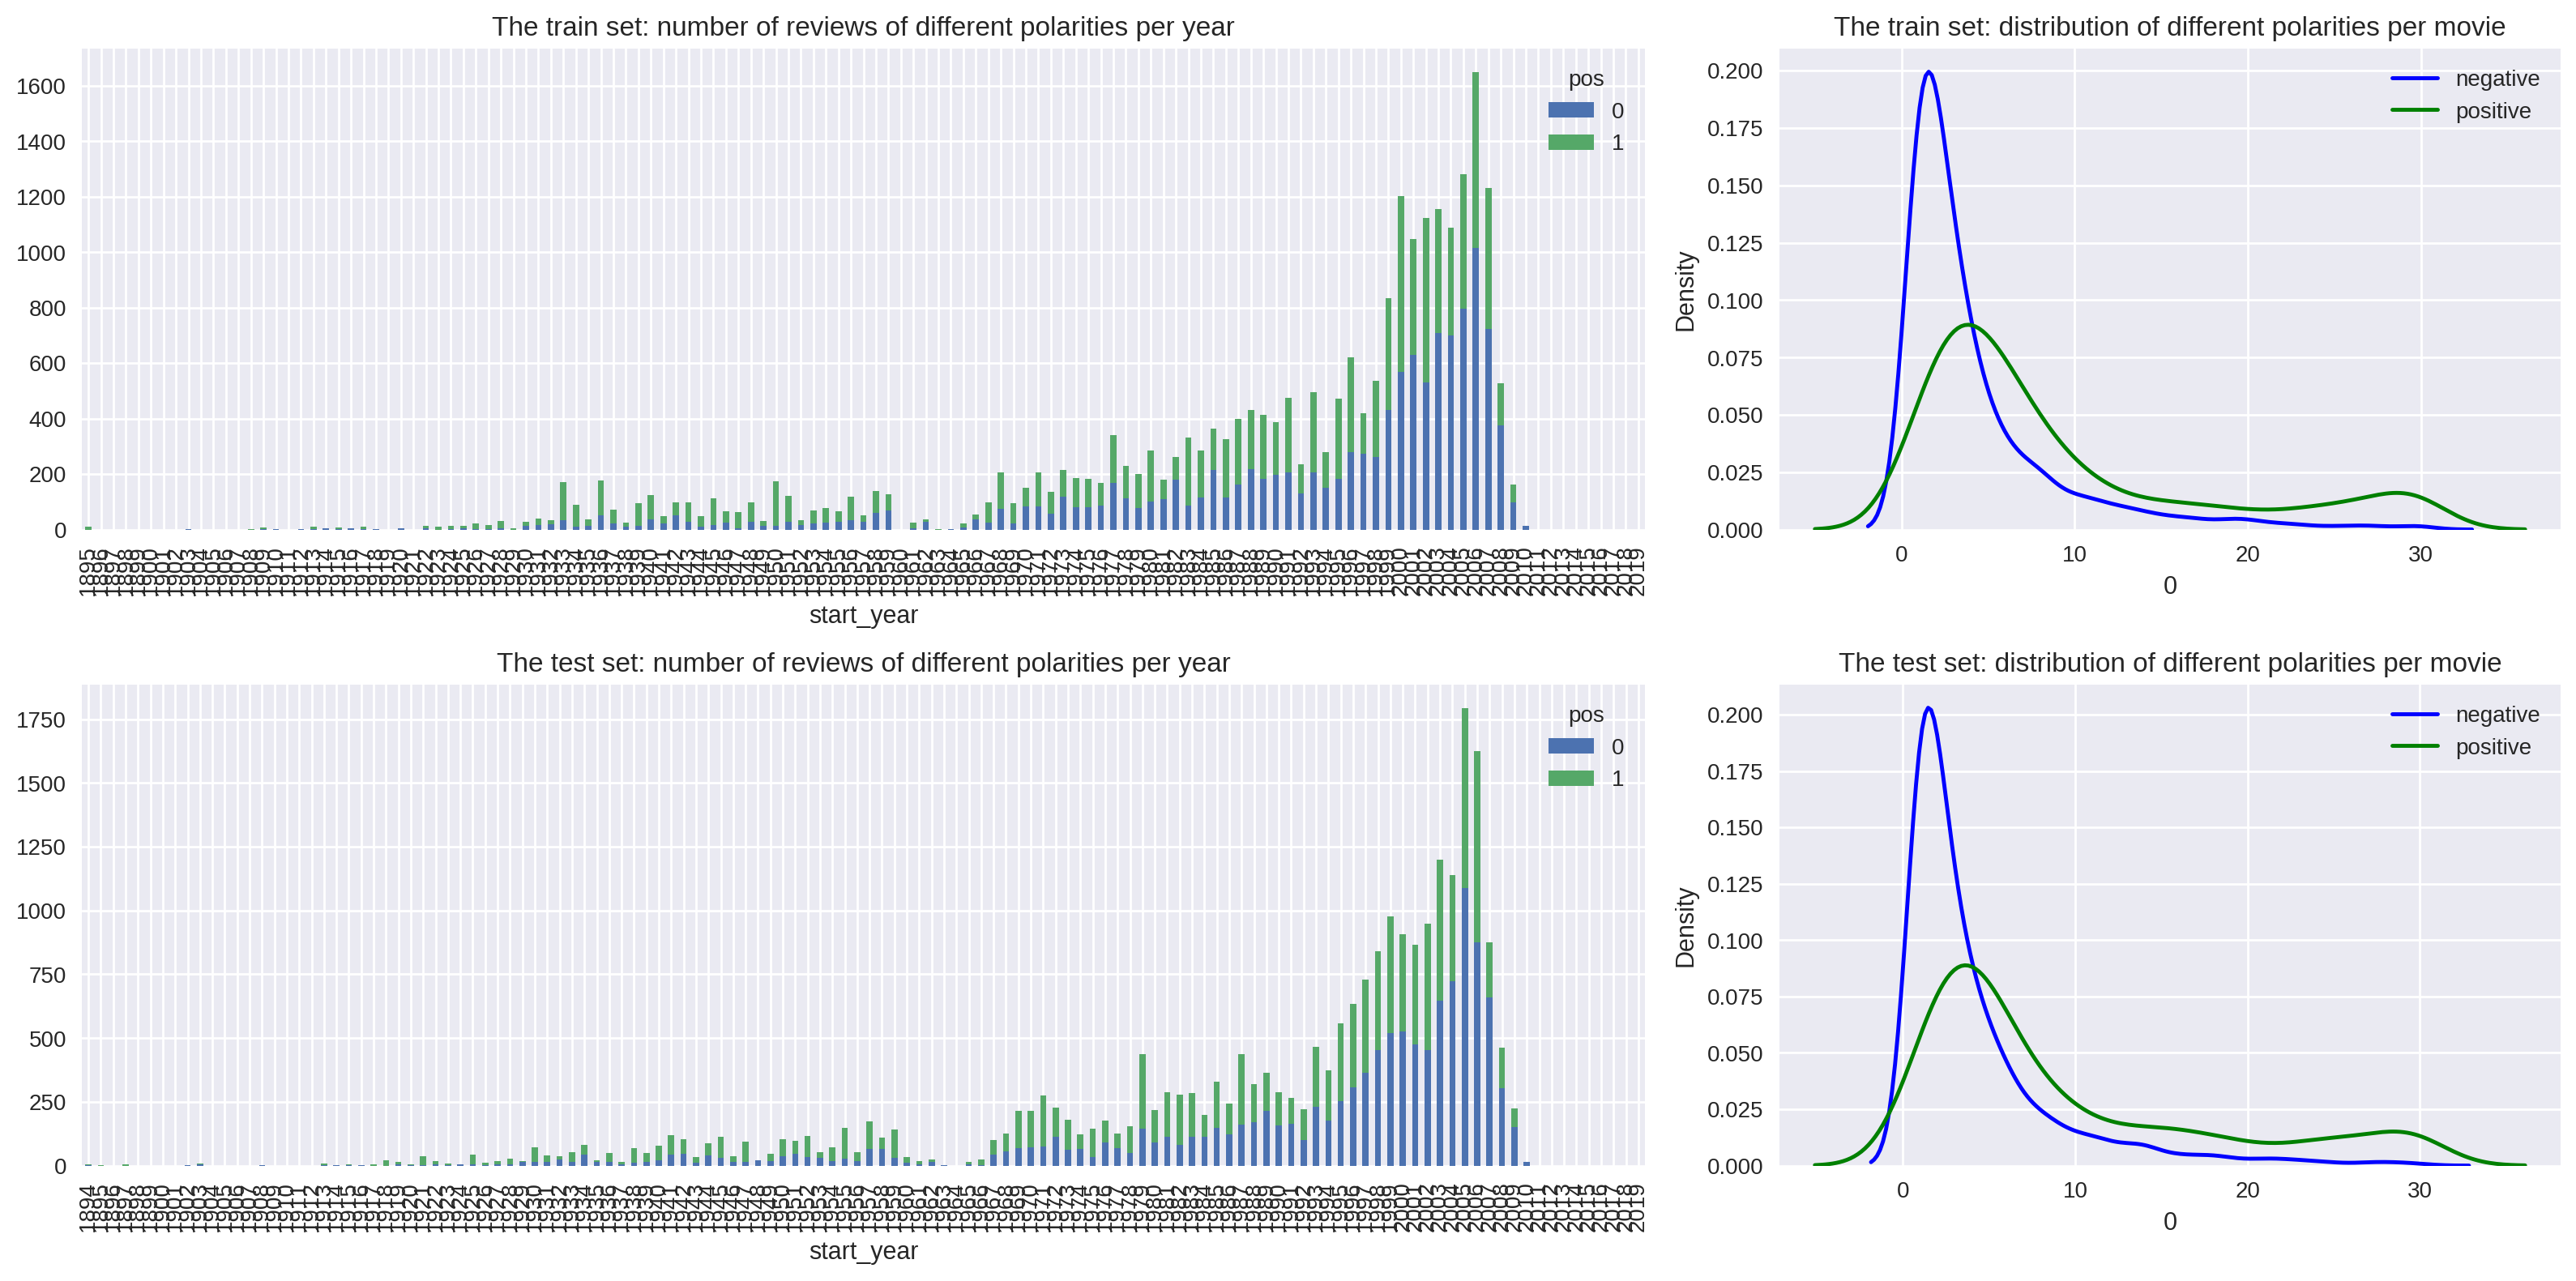

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Continiuing the trend from the previous graph, this shows that the train and test dataset do have a very similar class balance, which creates optimal conditions for model evaluation.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [12]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for data_type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[data_type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[data_type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[data_type]['APS'] = aps
        
        if data_type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{data_type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{data_type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{data_type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[data_type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[data_type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [13]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um  a serious film about troubled teens in sin...
4    im totally agree with garryjohal from singapor...
Name: review_norm, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [16]:
model_0 = DummyClassifier(strategy="constant", constant=1)
X_train = df_reviews_train.drop('pos', axis=1)
X_test = df_reviews_test.drop('pos', axis=1)
model_0.fit(X_train, train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


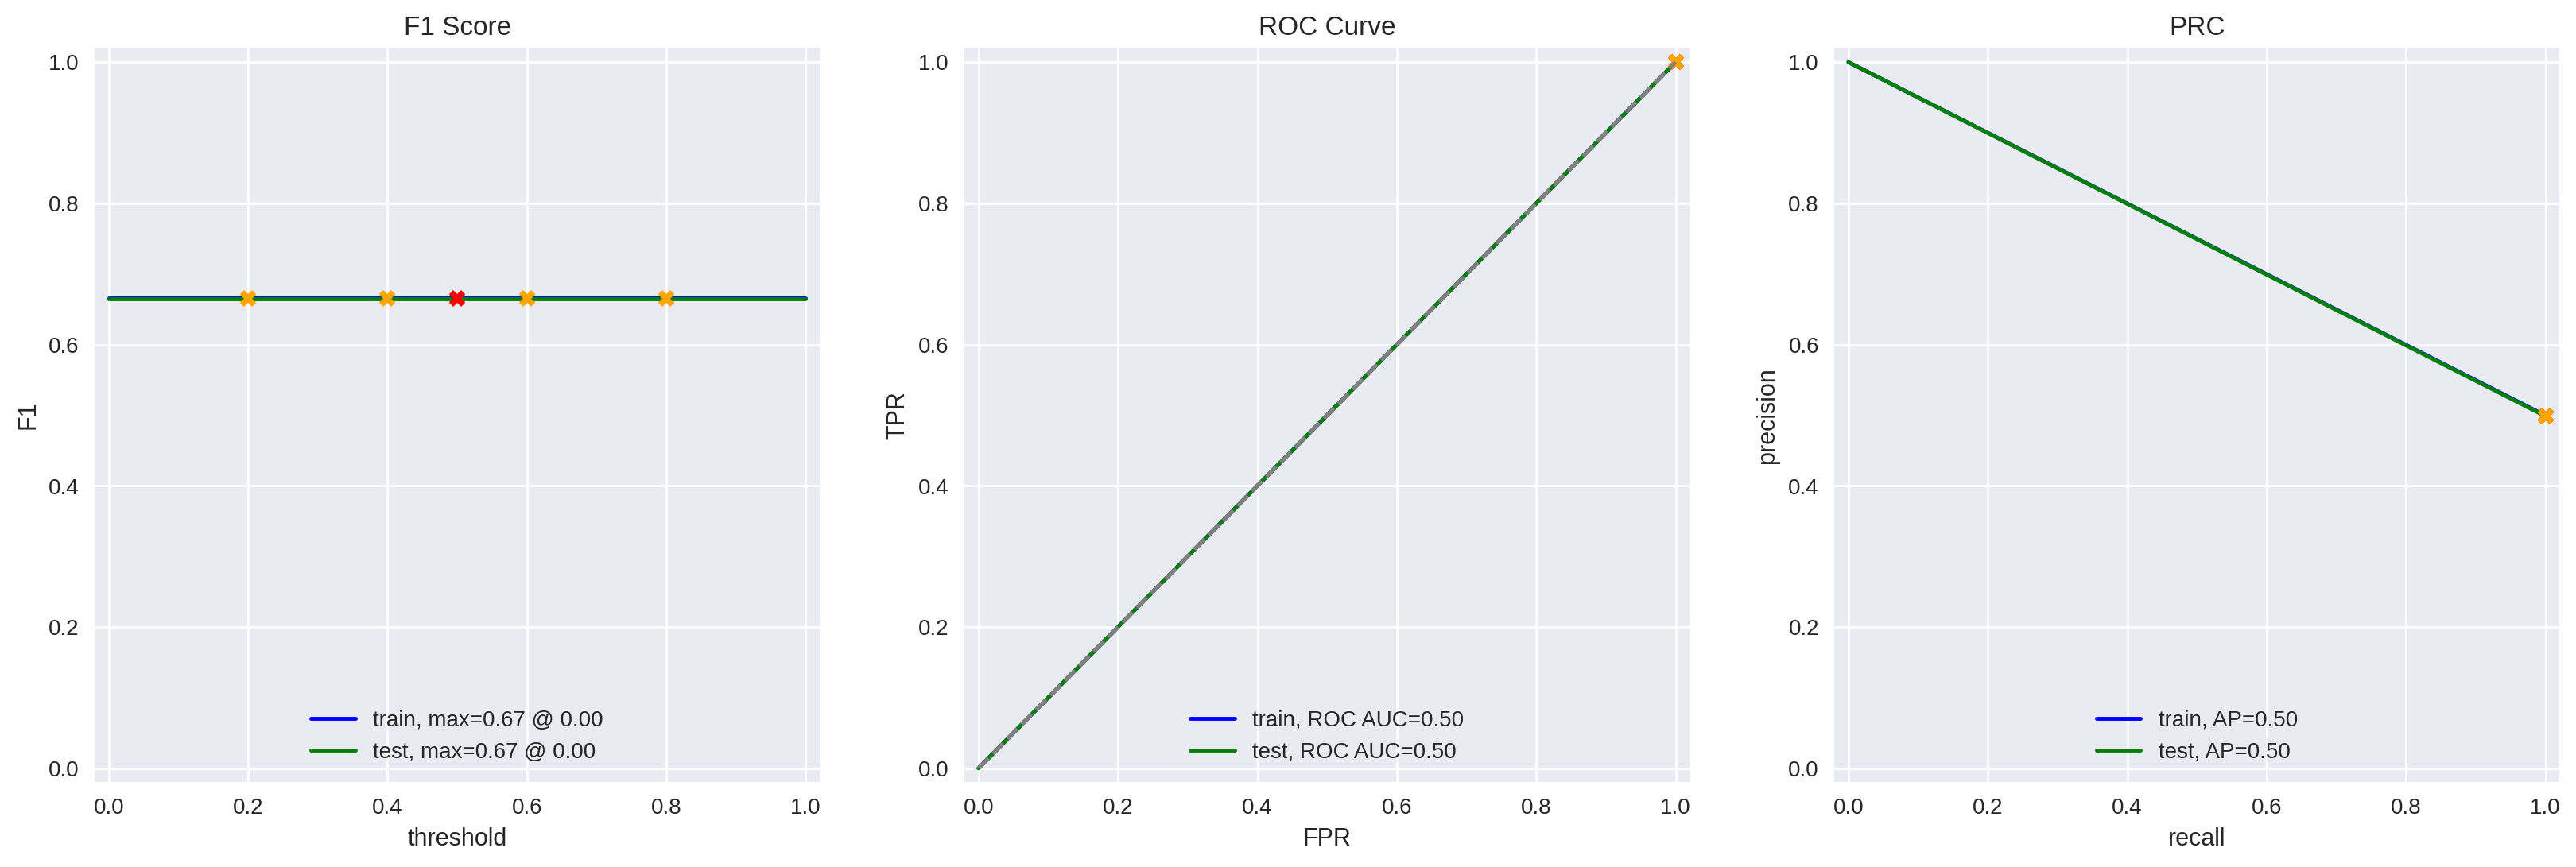

In [17]:
evaluate_model(model_0, X_train, train_target, X_test, test_target)

The Dummy model, also called the Sanity Check, preforms at random. This instance provides only 1 (pos) responses, and the evaluation reflects the random nature of the model. Every other model should outpreform this model.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [19]:
stop_words = list(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [20]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


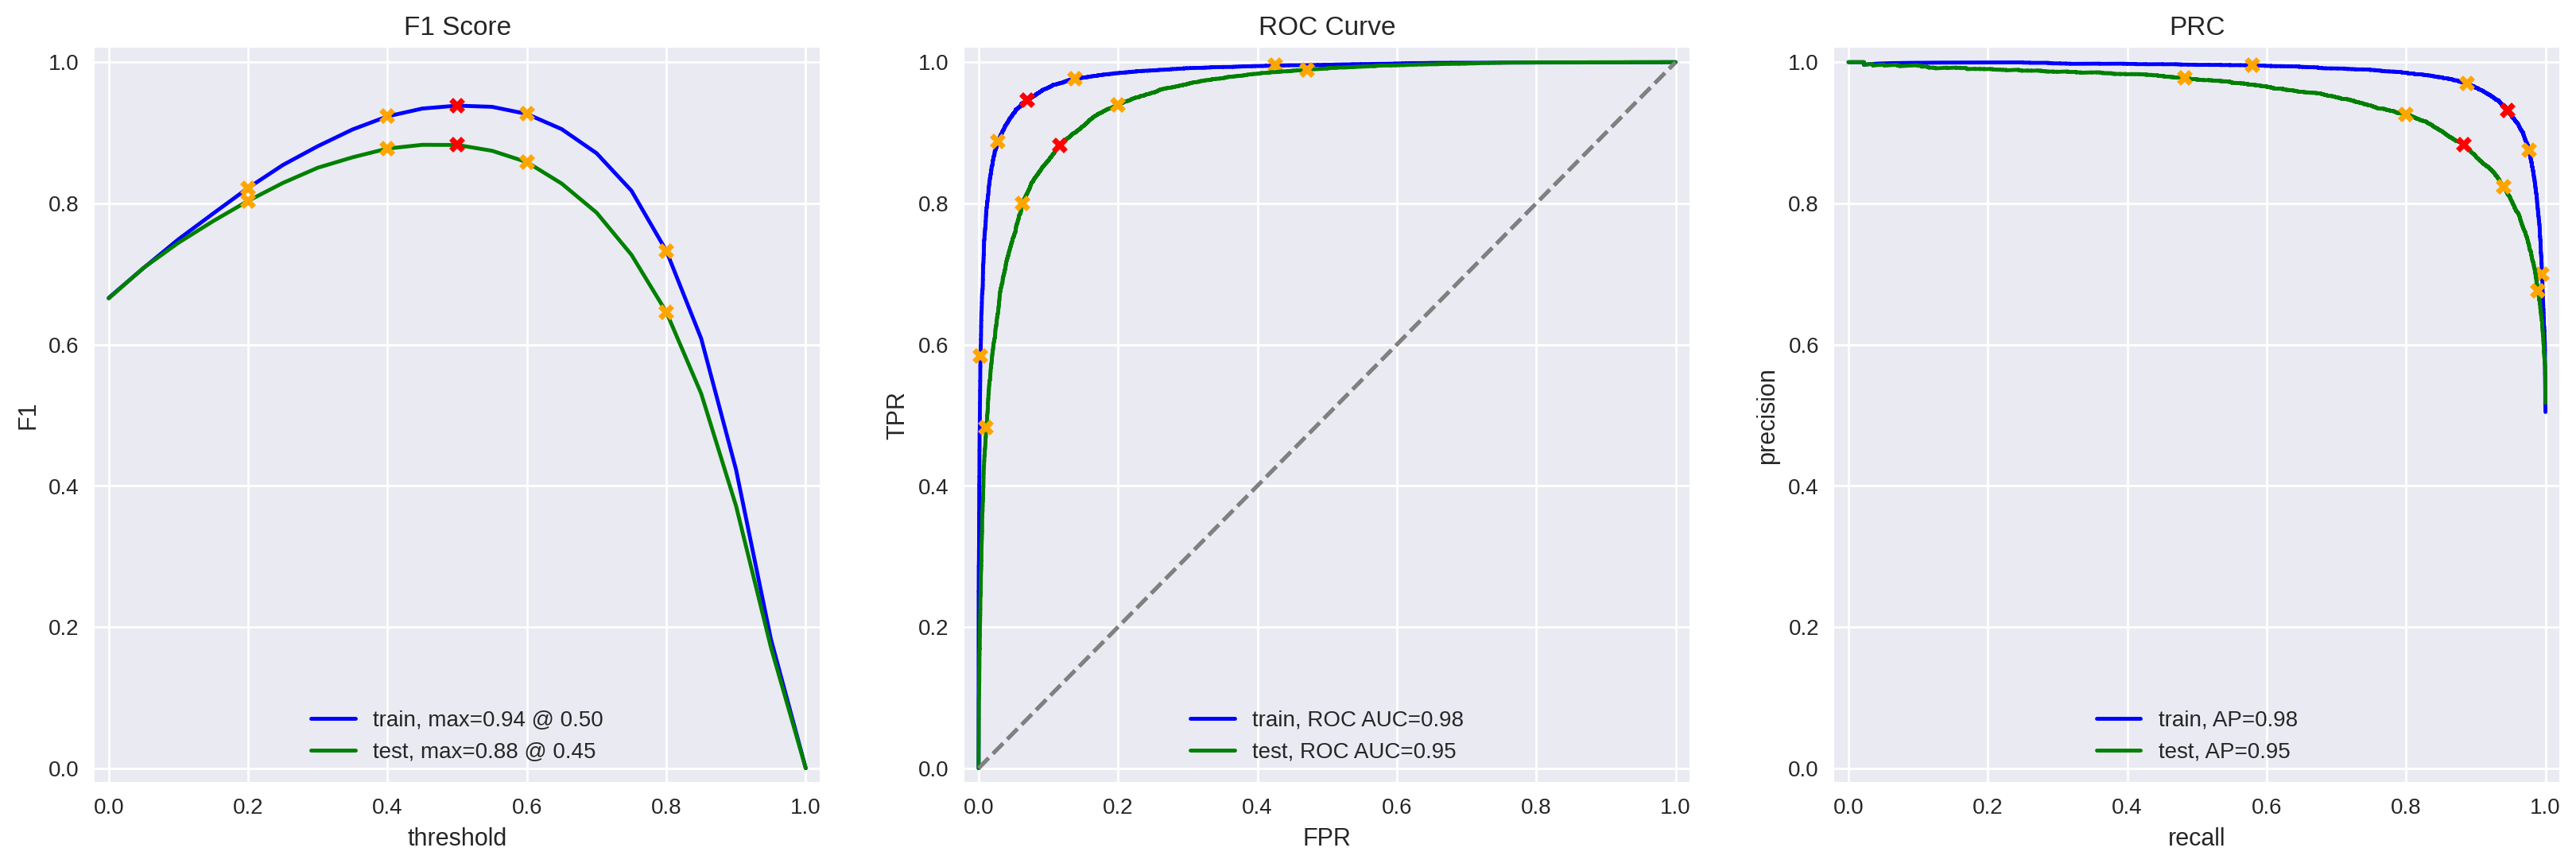

In [21]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

This first model preforms admirably well already, achieving almost perfect F1 and AUC ROC scores with the training dataset. 

### Model 2 - spaCy, TF-IDF and LR

In [22]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [23]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [24]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

df_reviews['review_spacy'] = df_reviews['review_norm'].apply(text_preprocessing_3)

train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews.query('ds_part == "train"')['review_spacy'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews.query('ds_part == "test"')['review_spacy'])

In [25]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


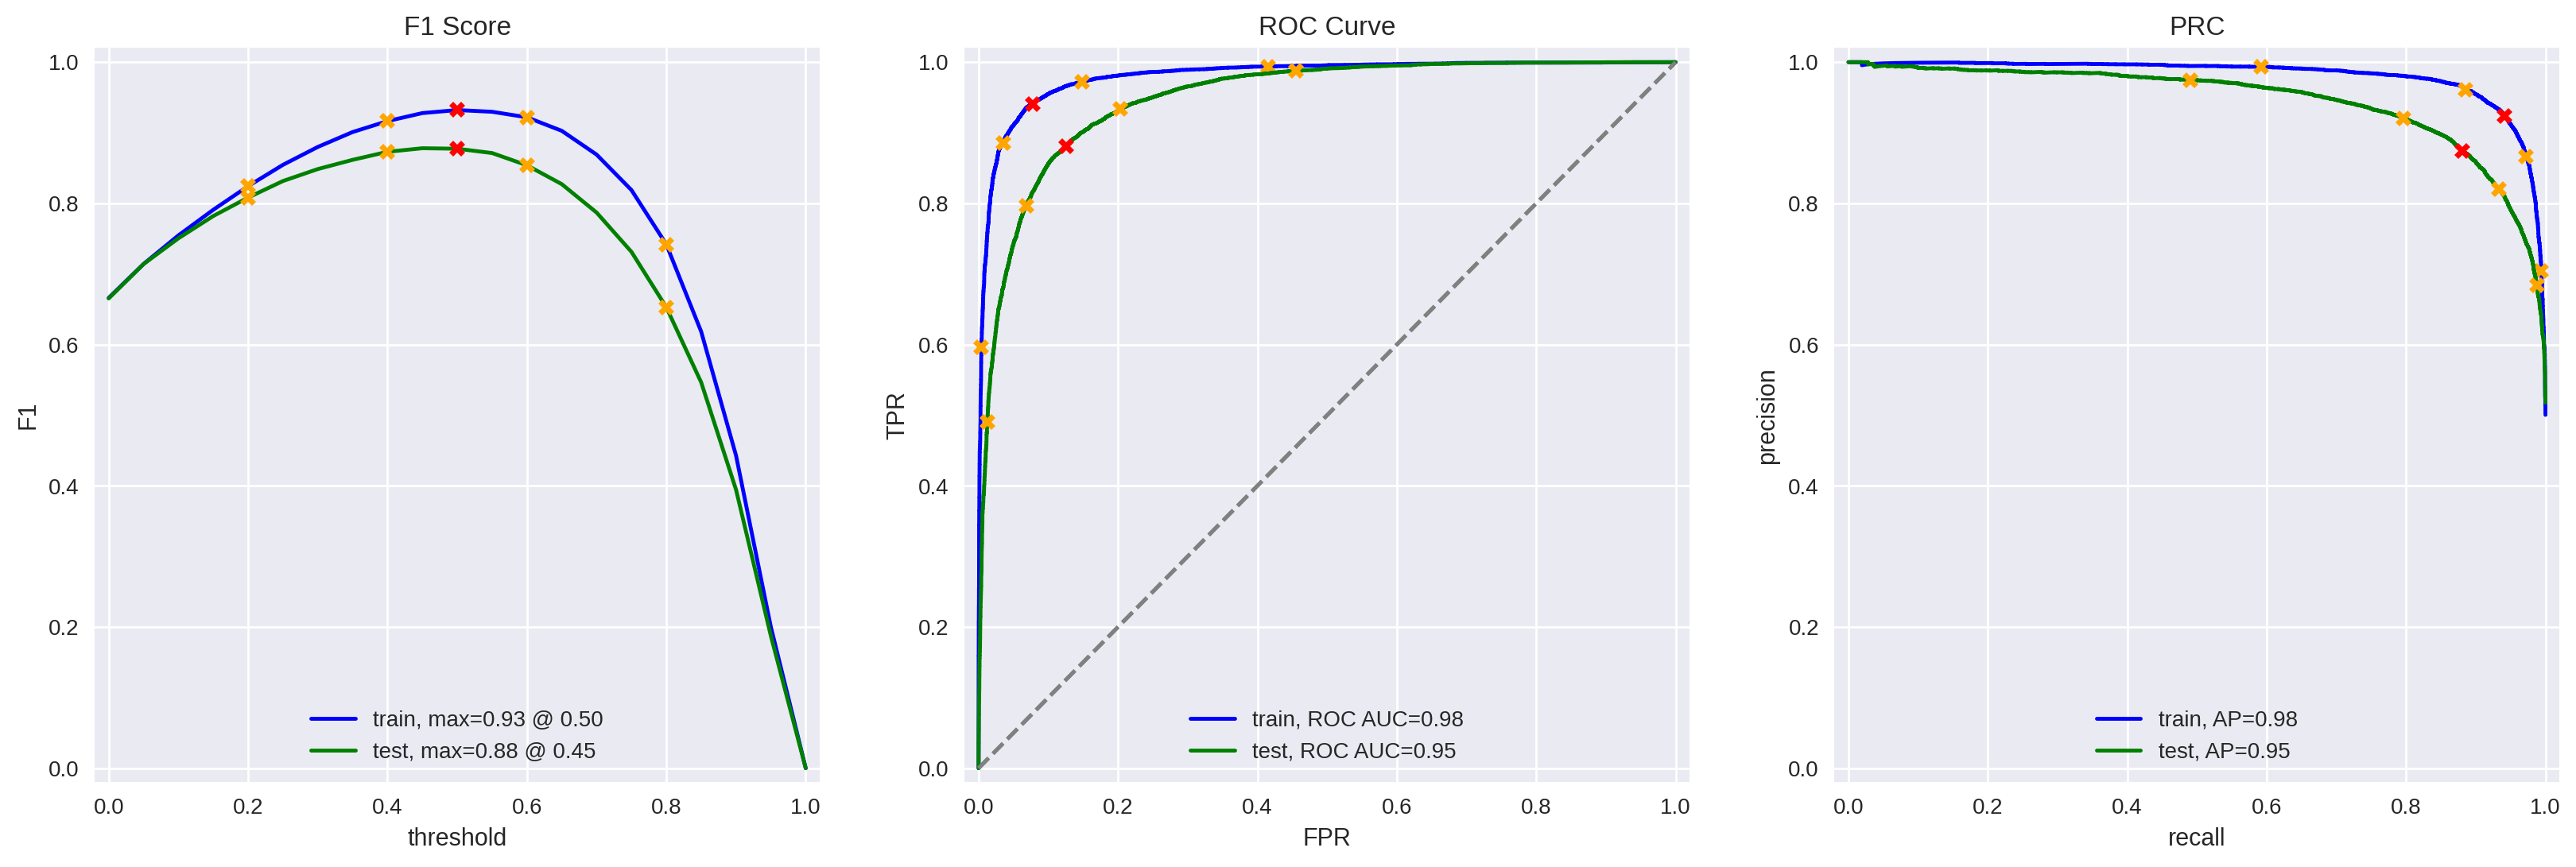

In [26]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

This model, also being a Logistic Regression, faired similarly to the previous model, with the test dataset. This model actually has a slightly lower F1 score, though only by 0.1, and it could merely be a difference in rounding.

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [28]:
model_3 = LGBMClassifier()
model_3.fit(train_features_2, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.93


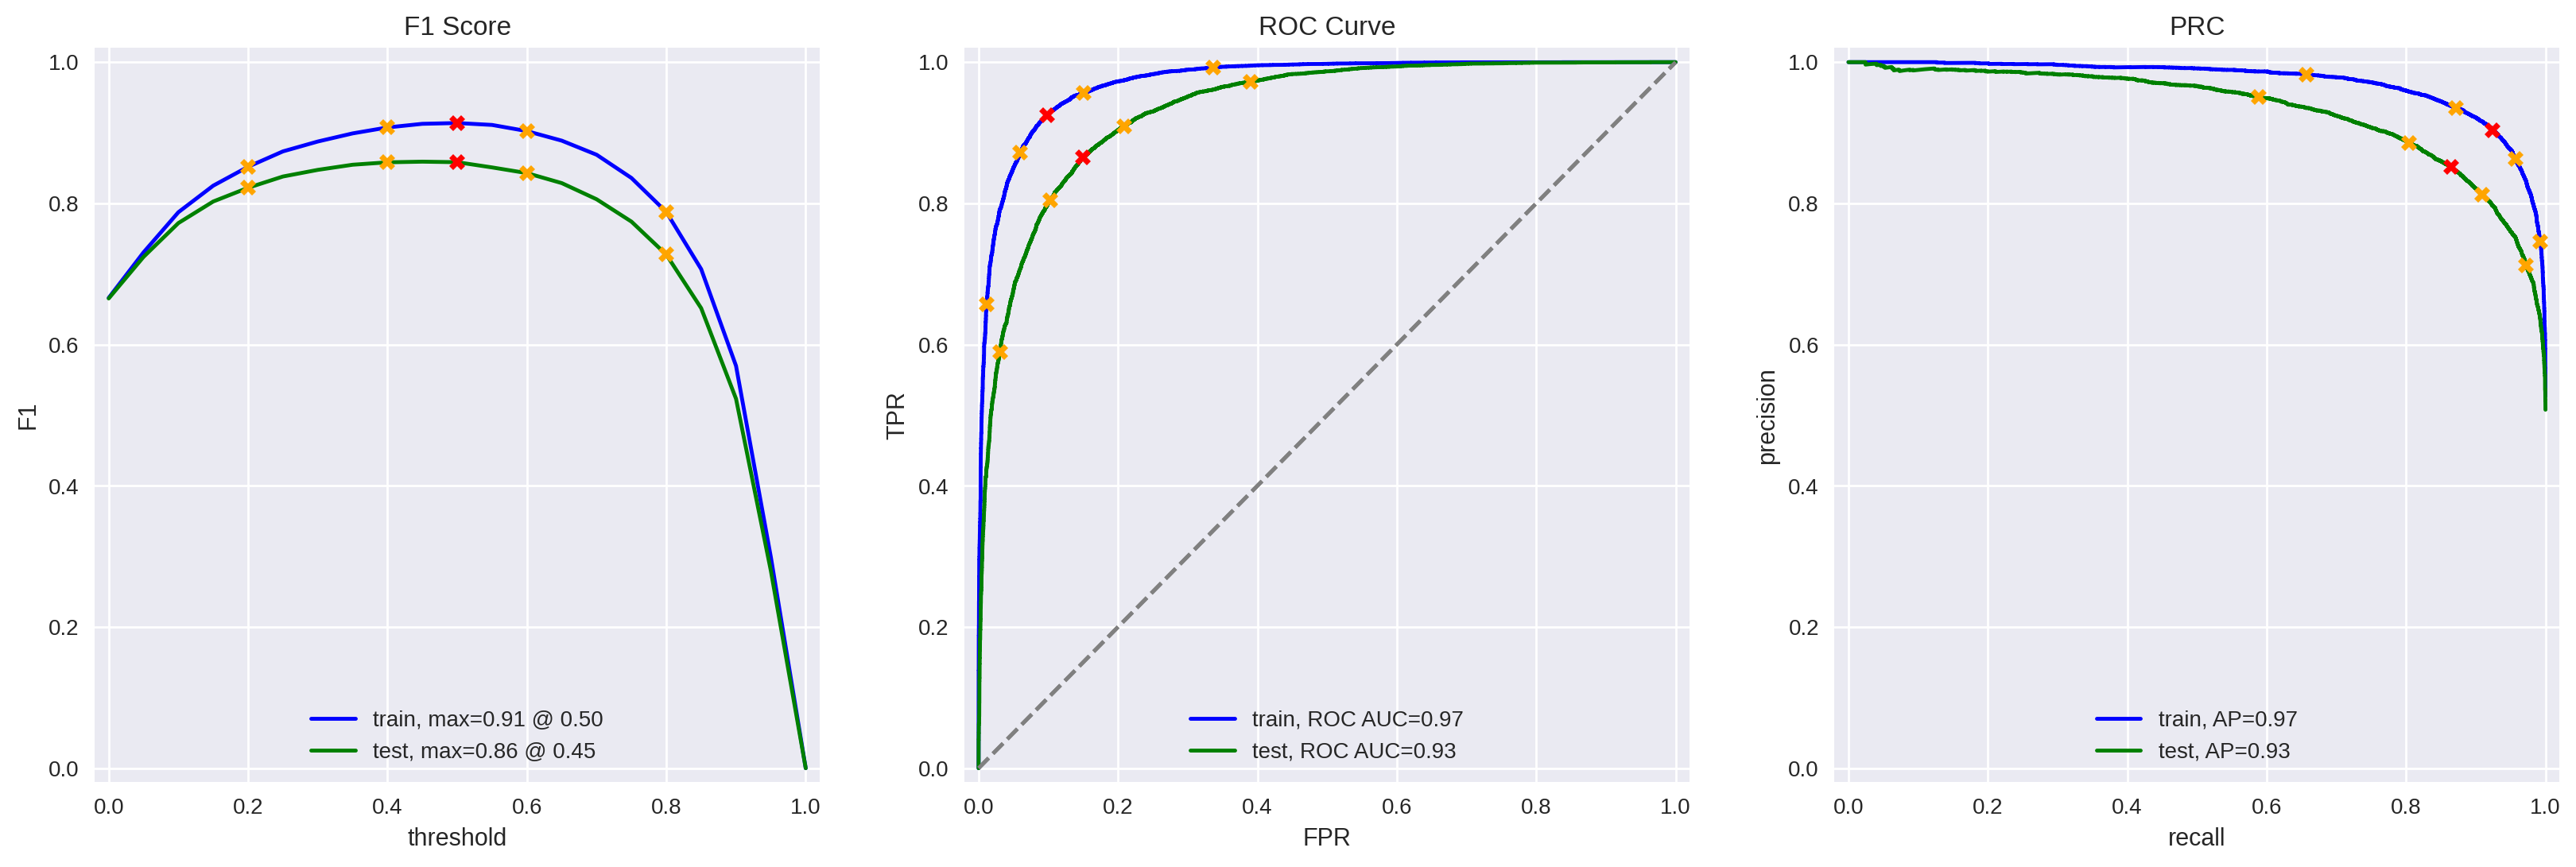

In [29]:
evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

This model was outpreformed by the other two, though it was remarkably more accurate than the dummy model, as would be expected.

###  Model 9 - BERT

In [30]:
import torch
import transformers

In [31]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [33]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [34]:
print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796,)


In [35]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [36]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 1

In [37]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.18:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.48:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 2

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.13:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.10:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [40]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_2
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.36:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.63:  i didnt expect the reboot to be so good writers really cared about the source material
0.65:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.24:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 9

In [41]:
texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

Model 2 outpreformed its competiors. This is partially due to range, as its scores ranged from 0.03 to 0.92, where the other models ranged from 0.05 to 0.84 and 0.24 to 0.80 respectively. The Logistic Regression models seem to put much heavier emphasis on the positive and negative connotations of the words in each review.

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions